Load libraries and matlab files

In [4]:
import h5py
import numpy as np
import scipy.io
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from __future__ import print_function

import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
arrays = {}
f = h5py.File(common_path + 'Feature_matrix.mat', 'r')
for k, v in f.items():
    arrays[k] = np.array(v)
    
X_train = arrays[k]

arrays = {}
f = h5py.File(common_path + 'newXTest_Pro_pipe.mat', 'r')
for k, v in f.items():
    arrays[k] = np.array(v)
    
newXTest_Pro_pipe = arrays[k]

X_train = np.transpose(X_train)

zero_padding = scipy.io.loadmat(common_path + 'zeropadding.mat')
shuffling = scipy.io.loadmat(common_path + 'shuffling.mat')
targetTest = scipy.io.loadmat(common_path + 'targetTestZeroPadding.mat')

labels = shuffling['Labels']
labels = np.squeeze(labels)

categoricalNewYTrain = []

for row in shuffling['newYTrain']:
    for index, column in enumerate(row):
        if column == 1:
            categoricalNewYTrain.append(index + 1)
            
y_train = np.array(categoricalNewYTrain)

Xtest_LADWP = zero_padding['newXTest_LADWP']
Xtest_Qian = zero_padding['newXTest_Qian']
Xtest_Pro_pipe = np.transpose(newXTest_Pro_pipe)

ytest_LADWP = targetTest['targetTest'][0][0]
ytest_Qian = targetTest['targetTest'][0][2]
ytest_Pro_pipe = targetTest['targetTest'][0][1]

categoricalYTest_LADWP = []

for row in ytest_LADWP:
    
    for index, column in enumerate(row):
        if column == 1:
            categoricalYTest_LADWP.append(index + 1)
            
ytest_LADWP = np.array(categoricalYTest_LADWP)

categoricalYTest_Qian = []

for row in ytest_Qian:
    
    for index, column in enumerate(row):
        if column == 1:
            categoricalYTest_Qian.append(index + 1)
            
ytest_Qian = np.array(categoricalYTest_Qian)

categoricalYTest_Pro_pipe = []

for row in ytest_Pro_pipe:
    
    for index, column in enumerate(row):
        if column == 1:
            categoricalYTest_Pro_pipe.append(index + 1)
            
ytest_Pro_pipe = np.array(categoricalYTest_Pro_pipe)

In [6]:
del zero_padding
del shuffling
del targetTest
del arrays
del newXTest_Pro_pipe
del categoricalNewYTrain
del categoricalYTest_Pro_pipe
del categoricalYTest_LADWP
del categoricalYTest_Qian

In [7]:
common_path = '/media/preethamam/Utilities-SSD/Xtreme_Programming/Angel/Comparison/'
# common_path = '/Users/angel/Sewerpipe/Comparison/'

In [8]:
# import jsonpickle

# with open(common_path + 'comparison_datasets.json', 'r') as outfile:
#     json_str = outfile.read()
#     dataset = jsonpickle.decode(json_str)     

# outfile.close()

In [9]:
# import pickle

# dbfile = open('comparison_datasets', 'rb')      
# dataset = pickle.load(dbfile)

# dbfile.close()

In [10]:
def prediction(clf, x_test, y_test):
    pred = clf.predict(x_test)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    print('F1 score: {}'.format(metrics.f1_score(y_test, pred, average='weighted')))
    print('Recall: {}'.format(metrics.recall_score(y_test, pred, average='weighted')))
    print('Precision: {}'.format(metrics.precision_score(y_test, pred, average='weighted')))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
    return score

In [15]:
# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    t0 = time()
    
    print("Prediction LADWP")
    f1score_ladwp = prediction(clf, Xtest_LADWP, ytest_LADWP)
    
    print("Prediction Qian")
    f1score_qian = prediction(clf, Xtest_Qian, ytest_Qian)
    
    print("Prediction Pro_pipe")
    f1score_propipe = prediction(clf, Xtest_Pro_pipe, ytest_Pro_pipe)
    test_time = time() - t0
    
    print("train time: %0.3fs" % test_time)
    
    avg_f1score = (f1score_ladwp + f1score_qian + f1score_propipe) / 3
    
    clf_descr = str(clf).split('(')[0]
    return clf_descr, f1score_ladwp, f1score_qian, f1score_propipe, avg_f1score, train_time, test_time

In [16]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(), "Perceptron"),
        (PassiveAggressiveClassifier(), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(7)]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='lsqr', tol=0.01)
train time: 122.977s
Prediction LADWP
accuracy:   0.145
F1 score: 0.08567214781945362
Recall: 0.14543956043956044
Precision: 0.15662142115591224
confusion matrix:
[[ 646    1   12   13 1719    7    0    0  115   26   28    1    1   31]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 654    0   12   22 1763    2    0    2   99   14   15    1    1   15]
 [ 690    0   21   18 1693    0    0    0  101   26   22    0    1   28]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [ 569    0    6   15 1692    1    0    0  237   34   10    0   10   26]
 [ 619    0    9   18 1804    

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.087
F1 score: 0.0372199371202339
Recall: 0.0865064316096961
Precision: 0.128018430261219
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 543    0   14   13 1467    1    0    0  115   13   11    0    5    0
     0   15]
 [ 620    0   23   16 1756    1    0    0  116   17   22    0    4    0
     0   25]
 [ 578    0   20   12 1518    0    0    0  111   11   15    0    0    0
     0   23]
 [ 673    0   24   16 1694    4    0    0  136   20   13    0    2    0
     0   18]
 [ 512    1   19   10 1335    0    0    1  108   18   12    0    0    0
     1   11]
 [ 650    0   28   18 1716    1    0    0  122   20   12    0    2    1
     0   30]
 [ 586    1   16   11 1808    0    0    1  115   15   22    1    0    0
     0   24]
 [ 624    0   23   13 1752    4    0    0  123   21   14    0    1    0
     0   25]
 [   0    0    0    0    0   

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.183
F1 score: 0.11408603326509348
Recall: 0.1834871794871795
Precision: 0.18124882094114447
confusion matrix:
[[2071    1   83   75 4717    1    1    1  684   54   56    0    1    0
     1   54]
 [ 679    0    7   18 1654    0    0    1  175   18   21    2    0    0
     0   25]
 [ 718    0   11   18 1488    0    0    0  257   29   32    0    0    0
     2   45]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [2087    0   86   73 4811    2    0    1  557   53   61    1    4    0
     4   60]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 559    2   10   13 1766    1    0    2  214   14    9    0    0    0
     2    8]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 704    0   16   17 1614

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 374.666s
Prediction LADWP
accuracy:   0.111
F1 score: 0.0810045617527889
Recall: 0.11148351648351648
Precision: 0.13567392518009744
confusion matrix:
[[1184    9  386   14  523    1    8  143  203   19    3   91    4    2
    10]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1249    9  258   10  543    4    6  136  182   17    5  152    5   14
    10]
 [1200    3  363   16  492    5   14  162  194   13    8  109    5    9
     7]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [1097    6  508   14  506    6    8  144  117   24    6  145    3    7
     9]
 [1318    3  296    5  534    7    8  119  175   17    1   97    4    8
     8]
 [1364    4  253    3  501    1    6  152  159   16    4  109    6   11
    11]
 [   0    0    0    0    0    0    0  

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.057
F1 score: 0.05517721647903183
Recall: 0.056628914057295136
Precision: 0.11437354363966021
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 996    8  252   10  472    4    0    8  112  196   19    4   99    2
     4   11]
 [1205    7  281    8  586    2    0    4  135  223   13    5  109    4
    10    8]
 [1040    6  269    9  483    7    0    5  111  203   15    4  116    6
     7    7]
 [1195    8  383    7  531    4    2    7  122  199   13    3  105    4
    10    7]
 [ 896    4  210    8  458    3    0    3  108  198   12    7  106    4
     3    8]
 [1231   12  277    4  552    8    0   10  136  216   16    6  115    7
     8    2]
 [1124   11  391    7  559    7    1    8  122  220   22    4  105    1
     8   10]
 [1171    5  310   12  577    6    0    8  137  226   12    3  113    5
    13    2]
 [   0    0    0    0   

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.150
F1 score: 0.11194091080797974
Recall: 0.1498974358974359
Precision: 0.12207767868507927
confusion matrix:
[[3593   19 1097   25 1476   17    0   21  442  611   36    9  406    8
    24   16]
 [1147    5  490    9  461    1    0    6  140  165   17    6  133    2
    11    7]
 [1233    5  468   12  473    4    0    4  116  156   17    3  100    4
     5    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [3639   16 1074   36 1466   18    0   21  424  574   42   10  421   11
    28   20]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1200    3  458   13  456    8    1    6  141  117   17    6  152    6
     9    7]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1308    4  291    5  439

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 778.672s
Prediction LADWP
accuracy:   0.067
F1 score: 0.08096186351151283
Recall: 0.06703296703296703
Precision: 0.14364966648810554
confusion matrix:
[[ 94 318  49 518  48  26   8 113 151 176 187  68 276 483  11  74]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 77 293  64 515  62  41  18  85 151 154 215  54 244 541  27  59]
 [106 296  62 511  52  43   4 100 133 150 178  52 303 533  18  59]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [179 407  79 389  46  18   9  77 177 122 317  88 161 440  25  66]
 [ 93 275  80 528  49  56  13  84 161 135 160  63 272 551  19  61]
 [ 81 315  70 449  43  39  26 103 170 147 174  62 307 523  24  67]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.053
F1 score: 0.06201985864617565
Recall: 0.05324655357966484
Precision: 0.12521670391616543
confusion matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 65 236  69 468  26  33   8  82 131 137 152  61 231 423  16  59]
 [ 71 277  74 509  55  29  17  95 170 147 179  89 254 539  22  73]
 [ 65 233  63 440  45  31  17  75 139 144 195  51 243 473  15  59]
 [ 73 267  73 572  49  31   8 106 169 132 223  45 211 568  18  55]
 [ 54 218  50 349  40  28  12  93 137  92 166  69 227 430  12  51]
 [ 64 276  66 480  58  37   9 102 169 151 226  69 251 549  23  70]
 [ 75 300  83 549  34  38   7 101 136 125 230  69 197 559  23  74]
 [ 75 290  69 547  53  33  18 101 139 135 177  56 260 535  18  94]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.054
F1 score: 0.05359515844686693
Recall: 0.05417948717948718
Precision: 0.1178035141594514
confusion matrix:
[[ 273  925  226 1413  146   74   29  276  520  476  651  198  931 1405
    63  194]
 [ 120  290   59  517   47   19   11   87  159  177  262   70  198  466
    29   89]
 [ 159  368   56  458   43   17    9   77  151  171  278   75  245  424
    11   58]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 272  874  255 1432  131   83   38  293  475  460  635  169  950 1468
    62  203]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  80  349   97  488   49   39    9   78  152  109  308   78  162  508
    19   75]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  88  307   89  464   38

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 2.155s
Prediction LADWP
accuracy:   0.125
F1 score: 0.10732529522289444
Recall: 0.12505494505494505
Precision: 0.14680546487228777
confusion matrix:
[[836  68 166 189 739  36  23  27 233  84  68  16  10  18  21  66]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [878  50 160 180 741  21  12  32 245  80  60  20  17  22  18  64]
 [802  69 170 178 788  27  19  36 208  82  88  19  10  17  21  66]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [793  74 157 185 837  22  15  25 247  72  84  15   7   9   7  51]
 [847  66 174 186 752  22  16  27 216  81  65  27  11  13  19  78]
 [859  70 205 174 705  26  22  22 259  77  70  16  20   9  22  44]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.071
F1 score: 0.06905583396175523
Recall: 0.07102957003023626
Precision: 0.11817693353505607
confusion matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [692  40 155 140 648  17  12  24 187  86  71  15  15  19  10  66]
 [827  55 177 185 715  41  21  17 254 109  75  12  13  12  18  69]
 [717  45 170 143 672  18  14  28 187  91  77  27  14  15  11  59]
 [805  52 172 175 811  29  20  27 233  87  67  21  11  19  13  58]
 [671  46 139 120 568  28   9  22 196  67  66  14  14  14   8  46]
 [859  49 184 168 739  42  18  18 223  89  83  20  13  12   7  76]
 [850  52 171 156 771  27  19  23 226  92  80  16  21  20  14  62]
 [841  63 184 165 748  28  27  17 226  92  90  22  11   6  14  66]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.140
F1 score: 0.11614317938280841
Recall: 0.13964102564102565
Precision: 0.12036064698610183
confusion matrix:
[[2461  177  552  532 2299   88   56   72  679  231  236   59   53   46
    41  218]
 [ 823   62  176  159  802   29   18   21  234  103   65   12   12   11
    11   62]
 [ 770   51  142  154  825   36   19   24  281  123   76    9    6   16
    10   58]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [2451  166  536  509 2339   98   71  103  658  239  223   51   47   56
    39  214]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 782   63  177  178  810   25   17   35  255   90   68   13   15    7
    13   52]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 842   60  146  184  79

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 6269.526s
Prediction LADWP
accuracy:   0.143
F1 score: 0.07832255214813018
Recall: 0.1431868131868132
Precision: 0.14430423245698107
confusion matrix:
[[ 739    3   15   13 1642    4    1    2  127   17   10    3    3    3
     2   16]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 705    0   21   17 1670    2    5    0  125   16   14    3    1    0
     3   18]
 [ 695    4   11   26 1687    4    1    2  114   22   13    2    2    2
     1   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 659    6   21   19 1722    1    0    2  106   17   16    4    2    5
     1   19]
 [ 702    7   17   30 1662    6    0    0  114   16   18    1    2    2


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.084
F1 score: 0.038879606763016904
Recall: 0.08379029365038693
Precision: 0.13034327433982257
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 560    6   18   16 1435    2    3    6   77   15   24    6    4    2
     5   18]
 [ 664    2   22   16 1689    3    2    2  123   23   16    5    3    3
     5   22]
 [ 584    6   19   26 1445    5    4    6   90   27   26    7    8    2
     4   29]
 [ 656    4   14   20 1737    4    2    3  104   11   17    1    1    3
     1   22]
 [ 540    4   14   16 1284    1    1    2  110   20   11    3    5    2
     0   15]
 [ 661    7   26   28 1651    5    2    7  113   22   31    4    9    4
    10   20]
 [ 653    5   22   15 1718    2    1    1  119   16   16    4    3    1
     2   22]
 [ 683    9   29   26 1631    4    8    8  106   25   21    7    5    5
     8   25]
 [   0    0    0    0   

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.185
F1 score: 0.1128847165889456
Recall: 0.1854871794871795
Precision: 0.12239309487312525
confusion matrix:
[[2014   10   45   57 5190    9   10    8  291   44   38   14   12    6
    10   42]
 [ 689    7   16   22 1685    3    2    1  112   15   20    2    2    1
     3   20]
 [ 663    6   11   23 1705    4    1    1  112   15   21    2    3    2
     4   27]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [2040   10   60   76 5022   15   10   16  308   59   62   17   15   15
    19   56]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 646    9   14   12 1751    1    1    1  123   10   12    0    2    2
     3   13]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 679    9   16   24 1643 

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 1359.544s
Prediction LADWP
accuracy:   0.135
F1 score: 0.09826451337470461
Recall: 0.13532967032967033
Precision: 0.1534981627884081
confusion matrix:
[[ 419   30   49   65 1510   19    8   26  169   74   88   15   17   15
    22   74]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 412   18   54   61 1528   16   13   23  195   56   88   27   18   18
    10   63]
 [ 455   16   40   72 1519   23    8   16  183   54   71   18   28   25
    16   56]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 370   15   62   47 1564   12   15   13  241   63   74   18   15   15
    20   56]
 [ 450   22   71   58 1512   18   13   22  167   67   59   18   19   15


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.087
F1 score: 0.05362964977545412
Recall: 0.08742889355814072
Precision: 0.1282393529956641
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 371   15   40   58 1246   18   16   23  158   60   49   22   15   19
    15   72]
 [ 398   24   50   50 1561   14   18   19  178   55   75   21   21   23
    23   70]
 [ 390   13   52   62 1320   18   18    8  153   53   68   14   19   12
    26   62]
 [ 458   14   51   72 1500   22   13   26  183   58   68   24   16   18
    17   60]
 [ 311   13   40   47 1180   10   17   13  164   54   61   14   23   17
    12   52]
 [ 419   29   66   69 1476   22   13   24  185   66   82   25   21   19
    18   66]
 [ 412   29   55   67 1508   18   16   23  162   75   81   19   18   24
    22   71]
 [ 409   20   50   74 1508   19   17   20  190   71   69   22   15   13
    26   77]
 [   0    0    0    0    0

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.160
F1 score: 0.11236471709366234
Recall: 0.16030769230769232
Precision: 0.12133745047196662
confusion matrix:
[[1278   57  150  210 4449   71   51   52  614  218  210   55   64   53
    62  206]
 [ 391   14   47   64 1532   13   14   23  180   76   67   24   18   22
    20   95]
 [ 451   21   46   68 1512   16   16   17  173   75   59   28   22   15
    18   63]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1271   63  188  213 4462   52   59   61  589  187  202   71   56   49
    73  204]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 372   13   75   55 1534   23   13   25  214   63   70   22   15   25
    21   60]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 436   23   57   57 149

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 482.726s
Prediction LADWP
accuracy:   0.106
F1 score: 0.08735199187021497
Recall: 0.10642857142857143
Precision: 0.1401548922797343
confusion matrix:
[[  10   88   15  223 1110  276   88   36  122  255   25  207    4   78
    34   29]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  20   82   13  286 1127  200   96   37  107  273   25  195    8   92
    23   16]
 [  28   80   17  215 1146  224   89   43  113  258   27  208    4   74
    25   49]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  17   68   26  164 1348  160   87   37  136  245   27  142    8   72
    30   33]
 [  29   99   12  271 1069  236  102   42   92  305   19  216    6   46
 

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.104
F1 score: 0.0876696813116988
Recall: 0.10403320863014401
Precision: 0.13275627211109342
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  24   66    9  186 1022  132   91   39   87  202   18  177    7   75
    35   27]
 [  21   77   10  275 1210  170   90   35  114  236   21  199   10   81
    28   23]
 [  19   56   15  220 1038  152  113   23   99  226   22  158   10   69
    39   29]
 [  29   76   14  234 1184  211   90   34  123  258   24  179    6   81
    34   23]
 [  18   64    7  188  944  103   98   42  101  176   15  164    4   66
    18   20]
 [  17  101   14  232 1221  177  106   41  107  236   28  187    5   79
    22   27]
 [  14   77   11  208 1187  217  128   36  114  252   29  182    7   90
    26   22]
 [  24   71   10  273 1198  196  109   38   98  244   20  182    6   76
    31   24]
 [   0    0    0    0    0

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.100
F1 score: 0.07527830337508447
Recall: 0.10046153846153846
Precision: 0.1274558733631478
confusion matrix:
[[  78  252   42  713 3347  633  306  116  351  872   53  579   20  253
    90   95]
 [  13   67   31  169 1170  219  112   47  114  312   21  186    9   59
    26   45]
 [  19   74   24  237 1197  166  117   57   78  293   11  173    9   71
    24   50]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  68  225   48  730 3260  667  332  112  339  868   64  621   25  254
    71  116]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  21   46   26  166 1311  201   94   45  126  249   23  152    6   76
    35   23]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  20   82   16  225 1084

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train time: 2765.122s
Prediction LADWP
accuracy:   0.142
F1 score: 0.09275480104146705
Recall: 0.1421978021978022
Precision: 0.14540950475473163
confusion matrix:
[[ 486    6   31   54 1649    4    0    4  188   41   61    5    2    2
     8   59]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 477    2   44   45 1663    5    2    4  192   47   63    4    1    2
     0   49]
 [ 497    8   28   59 1672    2    2    2  178   37   60    1    3    3
     2   46]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 429    3   33   39 1702    2    1    3  231   47   57    2    5    1
     3   42]
 [ 531    7   50   46 1642    3    2    7  163   37   43    4    4    4


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.089
F1 score: 0.04613343724395793
Recall: 0.08917132168298057
Precision: 0.10979674783920086
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 423    1   31   42 1387    1    2    3  166   36   40    4    0    2
     3   56]
 [ 462    3   29   36 1713    1    1    0  184   58   52    2    4    4
     5   46]
 [ 438    1   44   48 1435    2    1    3  154   40   58    3    4    2
     6   49]
 [ 527    1   32   53 1633    3    3    5  197   38   54    3    3    3
     5   40]
 [ 367    1   29   35 1290    1    0    4  167   34   50    3    1    3
     5   38]
 [ 492    5   45   45 1629    8    1    3  196   45   65    3    4    7
     5   47]
 [ 474    4   35   57 1669    0    1    2  180   55   60    2    4    2
     2   53]
 [ 477    4   33   57 1647    7    1    3  192   52   57    2    1    2
     7   58]
 [   0    0    0    0    

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.173
F1 score: 0.11073733561080548
Recall: 0.17294871794871794
Precision: 0.11429054015213665
confusion matrix:
[[1456   12  105  147 4865   15    6   11  664  160  164   12   13    8
    13  149]
 [ 446    2   26   49 1678    1    0    4  204   61   50    4    4    2
     7   62]
 [ 524    3   22   56 1641    2    2    3  181   56   48    4    4    2
     2   50]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1467   10  134  156 4917   11    4   13  620  127  154   15    8   10
    15  139]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 445    5   40   38 1673    5    1    4  221   47   58    5    2    6
     5   45]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 495    8   44   47 162

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 973.403s
Prediction LADWP
accuracy:   0.143
F1 score: 0.03571428571428571
Recall: 0.14285714285714285
Precision: 0.02040816326530612
confusion matrix:
[[   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]
 [   0    0 2600    0    0    0    0]]
Prediction Qian


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.117
F1 score: 0.02461169794575431
Recall: 0.11725516322451698
Precision: 0.01374877330280812
confusion matrix:
[[   0    0 2197    0    0    0    0    0]
 [   0    0 2600    0    0    0    0    0]
 [   0    0 2288    0    0    0    0    0]
 [   0    0 2600    0    0    0    0    0]
 [   0    0 2028    0    0    0    0    0]
 [   0    0 2600    0    0    0    0    0]
 [   0    0 2600    0    0    0    0    0]
 [   0    0 2600    0    0    0    0    0]]
Prediction Pro_pipe


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.200
F1 score: 0.06666666666666668
Recall: 0.2
Precision: 0.04
confusion matrix:
[[   0    0    0 7800    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 7800    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]
 [   0    0    0 2600    0    0    0    0    0    0    0]]
train time: 8.013s
Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(penalty='elasticnet')


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 992.265s
Prediction LADWP
accuracy:   0.135
F1 score: 0.04259302250732225
Recall: 0.135
Precision: 0.03146964071645237
confusion matrix:
[[   0    0    0  164    0 2436    0]
 [   0    0    0  247    0 2353    0]
 [   0    0    0  206    0 2394    0]
 [   0    0    0  113    0 2487    0]
 [   0    0    0  257    0 2343    0]
 [   0    0    0  256    0 2344    0]
 [   0    0    0  156    0 2444    0]]
Prediction Qian


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.012
F1 score: 0.01374407020908927
Recall: 0.011582022241582534
Precision: 0.016898573416450388
confusion matrix:
[[   0    0    0    0    0    0  170    0 2027]
 [   0    0    0    0    0    0  245    0 2355]
 [   0    0    0    0    0    0  214    0 2074]
 [   0    0    0    0    0    0  235    0 2365]
 [   0    0    0    0    0    0  182    0 1846]
 [   0    0    0    0    0    0  256    0 2344]
 [   0    0    0    0    0    0  226    0 2374]
 [   0    0    0    0    0    0  254    0 2346]
 [   0    0    0    0    0    0    0    0    0]]
Prediction Pro_pipe


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.064
F1 score: 0.011414749847738315
Recall: 0.06371794871794872
Precision: 0.007495225565098569
confusion matrix:
[[   0    0    0    0  611 7189    0    0    0    0    0]
 [   0    0    0    0  104 2496    0    0    0    0    0]
 [   0    0    0    0  121 2479    0    0    0    0    0]
 [   0    0    0    0  671 7129    0    0    0    0    0]
 [   0    0    0    0  137 2463    0    0    0    0    0]
 [   0    0    0    0  252 2348    0    0    0    0    0]
 [   0    0    0    0  217 2383    0    0    0    0    0]
 [   0    0    0    0  195 2405    0    0    0    0    0]
 [   0    0    0    0  177 2423    0    0    0    0    0]
 [   0    0    0    0  207 2393    0    0    0    0    0]
 [   0    0    0    0  198 2402    0    0    0    0    0]]
train time: 7.669s
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid()


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 21.540s
Prediction LADWP
accuracy:   0.025
F1 score: 0.027129208288360768
Recall: 0.025109890109890107
Precision: 0.033853971704073976
confusion matrix:
[[   0   22  162  386    0    1   22 1628    0  109    0    0   65  205
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    6  182  395    0    1   16 1640    0   98    0    0  102  160
     0]
 [   0   19  173  386    0    1   21 1608    1   93    0    0   92  206
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0   81   13  219    0    5  182 1506    0  194    0   23   59  318
     0]
 [   0   13  192  396    0    0   17 1641    0   62    0    0   77  202
     0]
 [   0   11  195  398    0    0   3

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.113
F1 score: 0.06210642511981296
Recall: 0.11300158868446676
Precision: 0.13685147235946127
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   9  112  324    0    0   20 1382    0   47    0   66  237]
 [  14  183  396    0    0   15 1640    0   51    0   70  231]
 [   8  135  343    0    1   14 1455    0   47    0   64  221]
 [  10  119  351    0    2   53 1615    0   89    0   80  281]
 [   9  116  306    0    0   11 1275    0   49    0   43  219]
 [   8  153  391    0    0   20 1630    0   46    0   61  291]
 [  11  122  371    0    1   34 1619    0   57    0   68  317]
 [   8  167  393    0    0   11 1648    0   54    1   81  237]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]
Prediction Pro_pipe


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.012
F1 score: 0.013614772305361792
Recall: 0.012333333333333333
Precision: 0.021048042627418315
confusion matrix:
[[   0   98  407 1080    0    4  147 4787    0  370    0    3  353  549
     0    2]
 [   0   43   76  305    0   12   95 1562    0  142    1    9  120  235
     0    0]
 [   0   78   58  279    0    3  123 1568    3  128    0    4  133  223
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0   79  466 1116    0    7  116 4842    1  377    0    5  346  444
     0    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0   27   43  249    0    1  151 1563    0  181    0    4   75  306
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0   21  162  388 

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 20.615s
Prediction LADWP
accuracy:   0.143
F1 score: 0.03864395792095885
Recall: 0.14307692307692307
Precision: 0.04711365467539548
confusion matrix:
[[  29    0 2571    0    0    0    0]
 [  23    0 2577    0    0    0    0]
 [  25    0 2575    0    0    0    0]
 [   7    0 2593    0    0    0    0]
 [  23    0 2577    0    0    0    0]
 [  22    0 2578    0    0    0    0]
 [  26    0 2574    0    0    0    0]]
Prediction Qian


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.116
F1 score: 0.024543539239522974
Recall: 0.11628145339004765
Precision: 0.013719676431334009
confusion matrix:
[[   0    0    0    0    0    0    0    0    0]
 [  13    0    0 2184    0    0    0    0    0]
 [  20    0    0 2580    0    0    0    0    0]
 [  19    0    0 2269    0    0    0    0    0]
 [  14    0    0 2586    0    0    0    0    0]
 [   8    0    0 2020    0    0    0    0    0]
 [   9    0    0 2591    0    0    0    0    0]
 [  11    0    0 2589    0    0    0    0    0]
 [  27    0    0 2573    0    0    0    0    0]]
Prediction Pro_pipe


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.200
F1 score: 0.06959869465750705
Recall: 0.2001025641025641
Precision: 0.09119013126162384
confusion matrix:
[[  62    0    0 7738    0    0    0    0    0    0    0]
 [   8    0    0 2592    0    0    0    0    0    0    0]
 [   9    0    0 2591    0    0    0    0    0    0    0]
 [  58    0    0 7742    0    0    0    0    0    0    0]
 [   8    0    0 2592    0    0    0    0    0    0    0]
 [  24    0    0 2576    0    0    0    0    0    0    0]
 [  11    0    0 2589    0    0    0    0    0    0    0]
 [  15    0    0 2585    0    0    0    0    0    0    0]
 [   9    0    0 2591    0    0    0    0    0    0    0]
 [  26    0    0 2574    0    0    0    0    0    0    0]
 [  12    0    0 2588    0    0    0    0    0    0    0]]
train time: 7.661s
________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01)


/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train time: 51.321s
Prediction LADWP
accuracy:   0.074
F1 score: 0.09734562446326203
Recall: 0.07445054945054945
Precision: 0.1813860139513279
confusion matrix:
[[430  37 284  81 105   8  55 258  67 152 227  26  19 595 155 101]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [435  21 259 112 127   5  61 255  70 156 222  23  20 600 159  75]
 [447  45 289 110 104   9  46 253  57 107 211  15  11 598 155 143]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [448  35 246 174 174  36  11 130 230  52 186  37  19 585  43 194]
 [429  35 230  81  87   6  98 307  48 123 220  24  30 601 192  89]
 [446  19 238  97  99   6  85 255  60 143 241  24  16 602 193  76]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.048
F1 score: 0.06520854598933082
Recall: 0.047609286116947674
Precision: 0.14107259857476626
confusion matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [383  29 194 132 122   6  48 166  55  88 200  12  28 508 119 107]
 [456  36 238 133 152   6  64 200  51 129 197  21  27 607 159 124]
 [412  27 196 138 124  12  66 150  54 101 192  10  19 533 152 102]
 [499  22 264 199 176  12  41 113 108 122 178  15  27 606 118 100]
 [356  17 185 113 109   3  49 158  52  99 158  16  15 475 127  96]
 [455  33 232 139 147   8  55 200  67 121 222  24  39 601 157 100]
 [468  42 255 171 163   4  39 139  99 112 212  24  23 603 122 124]
 [461  29 243 131 144   8  64 179  70 118 211  14  27 612 167 122]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.091
F1 score: 0.09379118600337505
Recall: 0.09138461538461538
Precision: 0.12523195758018282
confusion matrix:
[[1501   95  829  591  561   49   98  289  395  288  544   61   95 1763
   278  363]
 [ 458   43  254  203  169   24   25  125  146   87  167   31   32  572
    89  175]
 [ 507   45  241  244  226   45   12   74  161   62  115   29   19  601
    71  148]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1466   99  791  568  529   28  122  342  314  317  591   67  113 1769
   339  345]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 450   37  265  144  181   26   16  154  131   99  199   36   12  601
    79  170]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 478   48  251  166  17

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train time: 2875.162s
Prediction LADWP
accuracy:   0.135
F1 score: 0.09758609522231328
Recall: 0.13489010989010988
Precision: 0.15198778443794933
confusion matrix:
[[ 418   31   49   66 1508   19    7   25  169   74   88   16   18   15
    22   75]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 413   18   55   62 1522   16   13   25  193   57   90   27   18   18
    11   62]
 [ 457   16   37   70 1519   24    9   16  184   52   71   18   27   24
    19   57]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 370   16   60   48 1563   12   15   15  240   63   74   18   15   15
    20   56]
 [ 451   23   72   58 1506   18   14   21  172   65   59   18   19   15

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.087
F1 score: 0.053002795978059264
Recall: 0.08691641469789371
Precision: 0.12420218514715727
confusion matrix:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 371   16   37   58 1254   18   15   24  156   58   47   21   15   20
    15   72]
 [ 402   24   52   51 1559   14   17   20  178   56   74   20   19   23
    23   68]
 [ 391   13   52   63 1316   17   18    9  154   53   69   15   18   12
    26   62]
 [ 459   15   52   71 1498   21   13   26  186   56   67   24   15   18
    19   60]
 [ 317   14   42   46 1176   10   15   15  162   54   61   14   23   15
    12   52]
 [ 423   29   66   69 1479   21   13   23  183   64   83   26   21   19
    18   63]
 [ 414   29   52   72 1503   17   16   25  163   75   80   18   18   24
    23   71]
 [ 411   20   51   75 1506   19   20   19  189   70   68   22   14   13
    26   77]
 [   0    0    0    0   

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:   0.160
F1 score: 0.11255358004004921
Recall: 0.16030769230769232
Precision: 0.1216887676598498
confusion matrix:
[[1283   60  151  215 4445   69   51   49  615  215  207   53   62   53
    64  208]
 [ 393   14   47   66 1528   13   15   22  181   76   67   23   19   22
    20   94]
 [ 448   24   47   68 1514   13   16   17  173   74   57   28   21   15
    19   66]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1271   65  186  221 4454   53   58   61  592  184  205   70   54   48
    73  205]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 369   14   75   56 1534   21   13   25  213   63   69   23   15   25
    22   63]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 440   23   57   57 1493

/home/angel/anaconda3/envs/sewerpipe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import pickle

dbfile = open('comparison_results', 'ab') 
pickle.dump(results, dbfile)
dbfile.close()

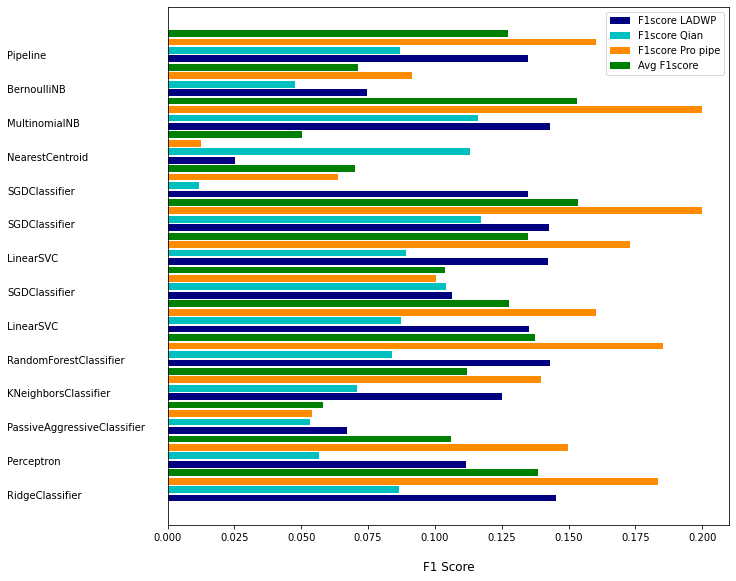

In [25]:
clf_names, f1score_ladwp, f1score_qian, f1score_propipe, avg_f1score, training_time, test_time = results

plt.figure(figsize=(12, 8))
plt.title("F1 Score", y=-0.1)
plt.barh(indices, f1score_ladwp, .2, label="F1score LADWP", color='navy')
plt.barh(indices + .25, f1score_qian, .2, label="F1score Qian",
         color='c')
plt.barh(indices + .5, f1score_propipe, .2, label="F1score Pro pipe", color='darkorange')
plt.barh(indices + .75, avg_f1score, .2, label="Avg F1score", color='green')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.06, i, c)

plt.show()

In [61]:
training_time

[122.97692203521729,
 374.66553020477295,
 778.6719715595245,
 2.1553213596343994,
 6269.525589227676,
 1359.5436170101166,
 482.7259249687195,
 2765.121779203415,
 973.4033722877502,
 992.2646176815033,
 21.54013752937317,
 20.61452031135559,
 51.32135081291199,
 2875.161511182785]

In [62]:
test_time

[1.431915283203125,
 8.007017374038696,
 7.934325218200684,
 5318.6883499622345,
 19.228942394256592,
 7.745882987976074,
 7.94009804725647,
 7.903364896774292,
 8.013257265090942,
 7.668957710266113,
 4.671772718429565,
 7.660913944244385,
 12.064477443695068,
 6.599537372589111]

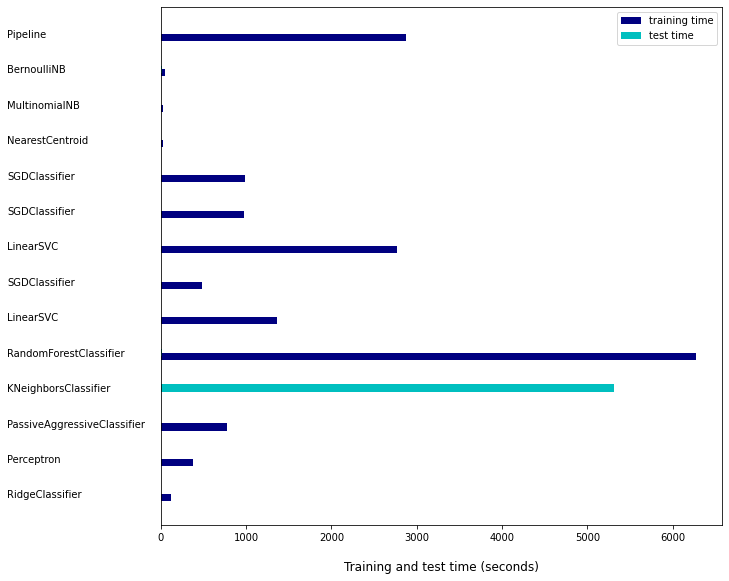

In [63]:
plt.figure(figsize=(12, 8))
plt.title("Training and test time (seconds)", y=-0.1)
plt.barh(indices, training_time, .2, label="training time", color='navy')
plt.barh(indices + .1, test_time, .2, label="test time",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-1800, i, c)

plt.show()